### Now Test on Test Dataset
* First import some libraries to measure the performance of the trained model on test dataset

In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras import optimizers
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
import itertools # for drawing confusion matrix
from itertools import cycle # for plotting ROC and PR curve
import matplotlib.pyplot as plt
import time

* Create a class label with integer number dictionary, `dict` type

In [2]:
dict_characters = {1:'Neutrophil', 2:'Eosinophil', 3:'Monocyte', 4:'Lymphocyte'}

* Load the the dataset (<b>.npz</b>) file.

In [3]:
npzfile = np.load('eswa_train_test_bccdwbc_seg_80x80.npz')

* Define userdefined function to draw confusion matix, plotting ROC and PR curve.

In [4]:
def plot_confusion_matrix(cm, classes,confMatName,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('./' + confMatName + '.png')

In [5]:
def plotROCcurve(n_classes, y_test, y_pred):
#     dict_char = 
    lw = 3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
#     print(fpr.shape,tpr.shape)
    plt.figure(figsize = (10,6))
    colors = cycle(['red', 'green', 'blue', 'black'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='AUC for class {0} {1:0.2f}'
             ''.format(dict_characters[i+1], roc_auc[i]))
    

    
#     plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('ROC Curve', size=20)
    plt.legend(loc="lower right", prop={'size': 20})
    plt.show()

In [6]:
def plotPrecRecallCurve(n_classes, Y_test, y_pred):
    # For each class
    labels = []
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_pred[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_pred[:, i])
    
    plt.figure(figsize = (10,6))
    colors = cycle(['red', 'green', 'blue', 'black'])
    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
#         lines.append(l)
        labels.append('AUC for class {0} {1:0.2f}'
                  ''.format(dict_characters[i+1], average_precision[i]))
    
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('Precision-Recall Curve', size=20)
    plt.legend(labels, loc="lower right", prop=dict(size=20))
    plt.show()

* User-defined function to load the trained CNN model and weights to test on test dataset. And also measure the different quality metrics to check the performance of the trained CNN model as well as draw and plot the confusion matrix, ROC, and PR curve.

In [7]:
def load_trainedcnn_calc_metrics(c,d):
    # load json model
    modelName = 'eswa_bccdwbc_cnn_model'
    json_file = open(modelName+'.json', 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.compile(loss=categorical_crossentropy,
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])
    model.summary()
    
    #load save weights of same model
    WeightFileName = 'eswa_bccdwbc_cnn_weights'
    model.load_weights(WeightFileName + '.hdf5', by_name=False)
    w1=model.get_weights()
    model.set_weights(w1)
    score = model.evaluate(c,d, verbose=1)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')

    #### Time Measurement Per Image Processing
    start_time_train = time.time()
    y_pred = model.predict(c)
    end_time = time.time()
    time_dif = end_time - start_time_train
    print('Time PerImage: {:.6} seconds'.format(time_dif/len(y_pred)))
    #### Time Measurement Per Image Processing    
    
#     print(y_pred.shape)
    map_characters = dict_characters
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
#     print(Y_pred_classes.shape)
#     print(Y_true.shape)

    cmm = confusion_matrix(Y_true, Y_pred_classes)
    plot_confusion_matrix(cmm, classes = list(dict_characters.values()), confMatName='eswa_bccdwbc_cnn_cm')
    plt.show()
    
    
    ###### Measuring matthews_corrcoef (MCC)
    TP = [cmm[0,0],cmm[1,1],cmm[2,2],cmm[3,3]]
    FP = [np.sum(cmm[1:4,0]), abs(TP[1]-np.sum(cmm[:,1])), abs(TP[2]-np.sum(cmm[:,2])), np.sum(cmm[0:3,3])]
    FN = [np.sum(cmm[0,1:4]), abs(TP[1]-np.sum(cmm[1,:])), abs(TP[2]-np.sum(cmm[2,:])), np.sum(cmm[3,0:3])]
    TN = [len(Y_true)-TP[0]-FP[0]-FN[0], len(Y_true)-TP[1]-FP[1]-FN[1], len(Y_true)-TP[2]-FP[2]-FN[2], len(Y_true)-TP[3]-FP[3]-FN[3]]
    print('TP: ', TP)
    print('TN: ', TN)
    print('FP: ', FP)
    print('FN: ', FN)
    print('\nMatthews Correlation Coefficient:')
    MCC = np.array([])
    for kk in range(len(TP)):
        mcc = ((TP[kk]*TN[kk])-(FP[kk]*FN[kk]))/np.sqrt((TP[kk]+FP[kk])*(TP[kk]+FN[kk])*(TN[kk]+FP[kk])*(TN[kk]+FN[kk]))
        MCC = np.append(MCC,mcc)
        print(dict_characters[kk+1], ': ', mcc)
    ###### Measuring matthews_corrcoef (MCC)
    
    # Measuring Cohen's Kappa Coefficient
    print('\nKappa: ', cohen_kappa_score(Y_true, Y_pred_classes))

    plotROCcurve(4, d, y_pred)
    plotPrecRecallCurve(4, d, y_pred)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   416         input_img[0][0]                  
__________________________________________________________________________________________________
Conv1_LeakyReLU (LeakyReLU)     (None, 40, 40, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
AvgPool_ForCCW_Conv1 (AveragePo (None, 40, 40, 3)    0           input_img[0][0]                  
______________________________________________________________________________________________

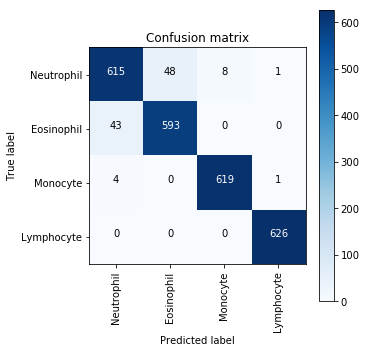

TP:  [615, 593, 619, 626]
TN:  [1839, 1874, 1926, 1930]
FP:  [47, 48, 8, 2]
FN:  [57, 43, 5, 0]

Matthews Correlation Coefficient:
Neutrophil :  0.8945883860169215
Eosinophil :  0.9050479475981195
Monocyte :  0.9862497889360123
Lymphocyte :  0.9978894661943126

Kappa:  0.9452577506171471


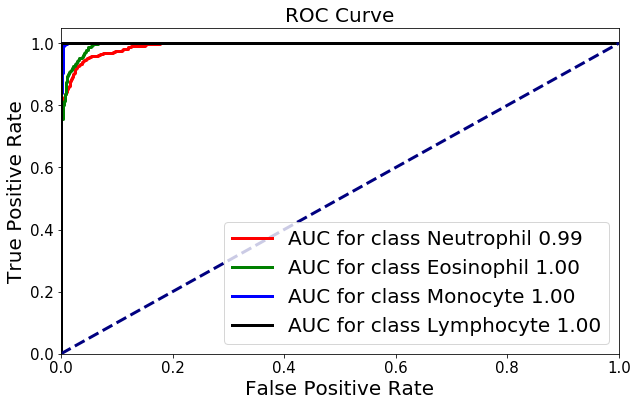

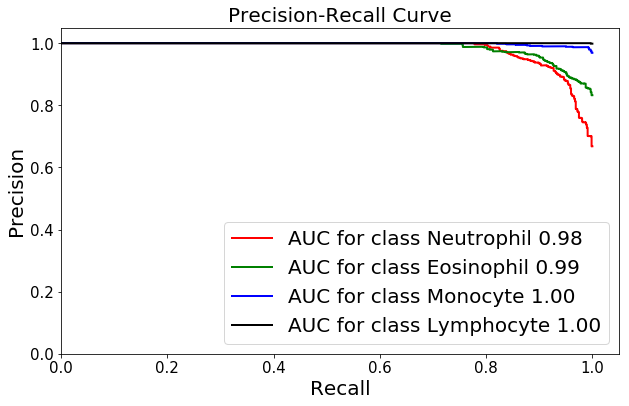

In [8]:
load_trainedcnn_calc_metrics(npzfile['X_test'], npzfile['y_testHot'])